In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
from PIL import Image
import matplotlib.gridspec as gridspec

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

2.17.1


In [ ]:
# Load the .npz file
#with np.load("./training_set.npz") as data:
with np.load("./drive/MyDrive/training_set.npz") as data:

    # Access the arrays by their names
    images = data["images"]  # Assuming 'images' is the key for image data
    labels = data["labels"]  # Assuming 'labels' is the key for label data

# Check the shape of the loaded data
print("Shape of images:", images.shape)
print("Shape of labels:", labels.shape)



Shape of images: (13759, 96, 96, 3)
Shape of labels: (13759, 1)


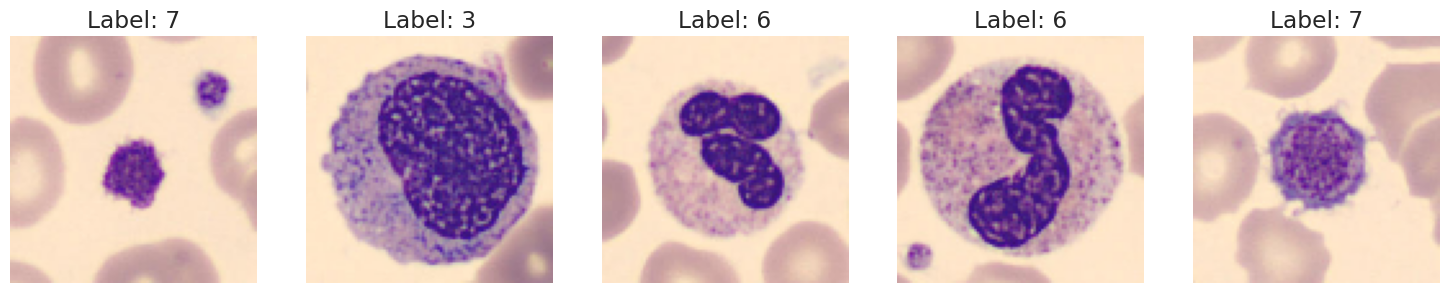

In [ ]:

# Number of images to display
num_images_to_display = 5

# Create a figure and axes for the images
fig, axes = plt.subplots(1, num_images_to_display, figsize=(15, 3))

# Iterate and display images
for i in range(num_images_to_display):
    # Display the image
    axes[i].imshow(images[i])
    axes[i].axis('off')  # Turn off axis labels and ticks
    axes[i].set_title(f"Label: {labels[i][0]}")  # Set title with label

# Adjust spacing and show the plot
plt.tight_layout()
plt.show()

In [ ]:
uniqueLabel = np.unique(labels)
unique, count = np.unique(labels, return_counts=True)


In [ ]:
# Batch size: number of samples processed in each training iteration
batch_size = 16

# Number of epochs: times the entire dataset is passed through the network during training
epochs = 100

In [ ]:

X_train_val, X_test, y_train_val, y_test = train_test_split(
    images,
    labels,
    test_size=0.2,
    random_state=seed,
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,
    y_train_val,
    random_state=seed,
    test_size=0.1,
    stratify=y_train_val
)


X_train = X_train / 255.0  # Assuming pixel values are in the range 0-255
X_val = X_val / 255.0
X_test = X_test / 255.0



from sklearn.preprocessing import StandardScaler

# Reshape data for StandardScaler
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
X_val_reshaped = X_val.reshape(X_val.shape[0], -1)
X_test_reshaped = X_test.reshape(X_test.shape[0], -1)

# Apply standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_reshaped)
X_val_scaled = scaler.transform(X_val_reshaped)
X_test_scaled = scaler.transform(X_test_reshaped)

# Reshape back to original shape
X_train = X_train_scaled.reshape(X_train.shape)
X_val = X_val_scaled.reshape(X_val.shape)
X_test = X_test_scaled.reshape(X_test.shape)

# Apply one-hot encoding to training labels
y_train = tfk.utils.to_categorical(y_train, num_classes=len(unique))

# Apply one-hot encoding to validation labels
y_val = tfk.utils.to_categorical(y_val, num_classes=len(unique))

# Apply one-hot encoding to test labels
y_test = tfk.utils.to_categorical(y_test, num_classes=len(unique))


In [ ]:
# Input shape for the model (get it from X_train)
input_shape = X_train.shape[1:]

# Output shape - needs to be the number of classes
# Assuming labels are integers representing classes, find the number of unique classes
num_classes = len(np.unique(y_train))

print("Input Shape:", input_shape)
print("Output Shape:", num_classes)  # Print number of classes


# Output shape for the model
output_shape = y_train.shape[1]

Input Shape: (96, 96, 3)
Output Shape: 2


Model: "MobileNetV3Small"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 96, 96, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 96, 96, 3)      │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv (Conv2D)             │ (None, 48, 48, 16)     │            432 │ rescaling_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_bn                   │ (None, 48, 48, 16)     │             64 │ conv[0][0]             │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_18             │ (None, 48, 48, 16)     │              0 │ conv_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 49, 49, 16)     │              0 │ activation_18[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 24, 24, 16)     │            144 │ expanded_conv_depthwi… │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 24, 24, 16)     │             64 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_14 (ReLU)           │ (None, 24, 24, 16)     │              0 │ expanded_conv_depthwi… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_squeeze_ex… │ (None, 1, 1, 16)       │              0 │ re_lu_14[0][0]         │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_squeeze_ex… │ (None, 1, 1, 8)        │            136 │ expanded_conv_squeeze… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_squeeze_ex… │ (None, 1, 1, 8)        │              0 │ expanded_conv_squeeze… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_squeeze_ex… │ (None, 1, 1, 16)       │            144 │ expanded_conv_squeeze… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_9 (Add)               │ (None, 1, 1, 16)       │              0 │ expanded_conv_squeeze… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_15 (ReLU)      

 Total params: 939,120 (3.58 MB)

 Trainable params: 927,008 (3.54 MB)

 Non-trainable params: 12,112 (47.31 KB)

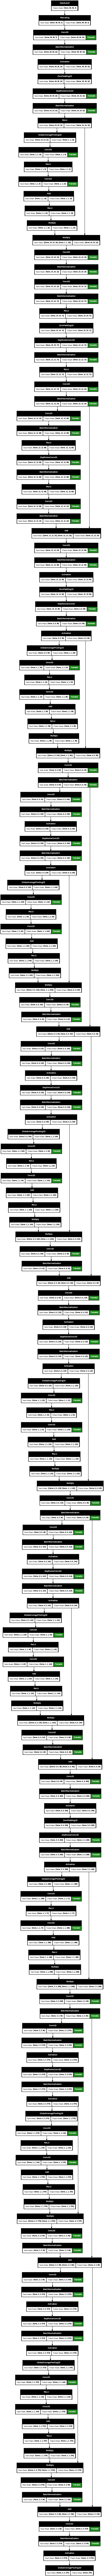

In [ ]:
# Initialise MobileNetV3Small model with pretrained weights, for transfer learning
mobilenet = tfk.applications.MobileNetV3Small(
    input_shape=input_shape,
    include_top=False,
    weights='imagenet',
    pooling='avg',
    include_preprocessing=True
)

# Display a summary of the model architecture
mobilenet.summary(expand_nested=True)

# Display model architecture with layer shapes and trainable parameters
tfk.utils.plot_model(mobilenet, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ preprocessing (Sequential)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_flip_1 (RandomFlip)      │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_translation_1            │ (None, 96, 96, 3)           │               0 │
│ (RandomTranslation)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MobileNetV3Small (Functional)        │ (None, 576)                 │         939,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ input_layer_2 (InputLayer)      │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ rescaling_1 (Rescaling)         │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ conv (Conv2D)                   │ (None, 48, 48, 16)          │             432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ conv_bn (BatchNormalization)    │ (None, 48, 48, 16)          │              64 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ activation_18 (Activation)      │ (None, 48, 48, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ expanded_conv_depthwise_pad     │ (None, 49, 49, 16)          │               0 │
│ (ZeroPadding2D)                      │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ expanded_conv_depthwise         │ (None, 24, 24, 16)          │             144 │
│ (DepthwiseConv2D)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ expanded_conv_depthwise_bn      │ (None, 24, 24, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ re_lu_14 (ReLU)                 │ (None, 24, 24, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └                                 │ (None, 1, 1, 16)            │               0 │
│ expanded_conv_squeeze_excite_avg_po… │                             │                 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └                                 │ (None, 1, 1, 8)             │             136 │
│ expanded_conv_squeeze_excite_conv    │                             │                 │
│ (Conv2D)                             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └                                 │ (None, 1, 1, 8)             │               0 │
│ expanded_conv_squeeze_excite_relu    │                             │              

 Total params: 943,736 (3.60 MB)

 Trainable params: 4,616 (18.03 KB)

 Non-trainable params: 939,120 (3.58 MB)

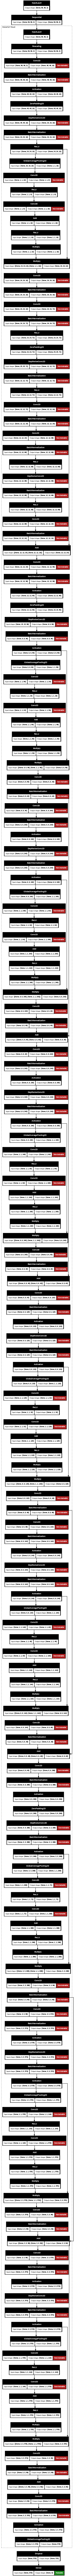

In [ ]:
# Freeze all layers in MobileNetV3Small to use it solely as a feature extractor
mobilenet.trainable = False

# Define input layer with shape matching the input images
inputs = tfk.Input(shape=input_shape, name='input_layer')

# Apply data augmentation for training robustness
augmentation = tf.keras.Sequential([
    tfkl.RandomFlip("horizontal"),
    tfkl.RandomTranslation(0.2, 0.2)
], name='preprocessing')

x = augmentation(inputs)

# Pass augmented inputs through the MobileNetV3Small feature extractor
x = mobilenet(x)

# Add a dropout layer for regularisation
x = tfkl.Dropout(0.3, name='dropout')(x)

# Add final Dense layer for classification with softmax activation
outputs = tfkl.Dense(y_train.shape[-1], activation='softmax', name='dense')(x)

# Define the complete model linking input and output
tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model with categorical cross-entropy loss and Adam optimiser
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])

# Display a summary of the model architecture
tl_model.summary(expand_nested=True)

# Display model architecture with layer shapes and trainable parameters
tfk.utils.plot_model(tl_model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

In [ ]:
# Train the model
tl_history = tl_model.fit(
    x=X_train ,
    y=y_train,
    batch_size=64,
    epochs=100,
    validation_data=(X_val, y_val),
    callbacks=[tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True)]
).history

# Calculate and print the best validation accuracy achieved
final_val_accuracy = round(max(tl_history['val_accuracy']) * 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file, including final accuracy in the filename
model_filename = 'Pets_MobileNetV3S_' + str(final_val_accuracy) + '.keras'
tl_model.save(model_filename)

# Free memory by deleting the model instance
#del tl_model

Epoch 1/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.2331 - loss: 1.9765 - val_accuracy: 0.4650 - val_loss: 1.6406
Epoch 2/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.3798 - loss: 1.7074 - val_accuracy: 0.4723 - val_loss: 1.5161
Epoch 3/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.4269 - loss: 1.6013 - val_accuracy: 0.4859 - val_loss: 1.4481
Epoch 4/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.4544 - loss: 1.5438 - val_accuracy: 0.4995 - val_loss: 1.4019
Epoch 5/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.4621 - loss: 1.4985 - val_accuracy: 0.5032 - val_loss: 1.3720
Epoch 6/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.4780 - loss: 1.4638 - val_accuracy: 0.5095 - val_loss: 1.3438
Epoch 7/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.4765 - loss: 1.4496 - val_accuracy: 0.5177 - val_loss: 1.3191
Epoch 8/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.4877 - loss: 1.4270 - 

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ preprocessing (Sequential)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_flip_1 (RandomFlip)      │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_translation_1            │ (None, 96, 96, 3)           │               0 │
│ (RandomTranslation)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MobileNetV3Small (Functional)        │ (None, 576)                 │         939,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ input_layer_2 (InputLayer)      │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ rescaling_1 (Rescaling)         │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ conv (Conv2D)                   │ (None, 48, 48, 16)          │             432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ conv_bn (BatchNormalization)    │ (None, 48, 48, 16)          │              64 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ activation_18 (Activation)      │ (None, 48, 48, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ expanded_conv_depthwise_pad     │ (None, 49, 49, 16)          │               0 │
│ (ZeroPadding2D)                      │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ expanded_conv_depthwise         │ (None, 24, 24, 16)          │             144 │
│ (DepthwiseConv2D)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ expanded_conv_depthwise_bn      │ (None, 24, 24, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ re_lu_14 (ReLU)                 │ (None, 24, 24, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └                                 │ (None, 1, 1, 16)            │               0 │
│ expanded_conv_squeeze_excite_avg_po… │                             │                 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └                                 │ (None, 1, 1, 8)             │             136 │
│ expanded_conv_squeeze_excite_conv    │                             │                 │
│ (Conv2D)                             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └                                 │ (None, 1, 1, 8)             │               0 │
│ expanded_conv_squeeze_excite_relu    │                             │              

 Total params: 952,970 (3.64 MB)

 Trainable params: 4,616 (18.03 KB)

 Non-trainable params: 939,120 (3.58 MB)

 Optimizer params: 9,234 (36.07 KB)

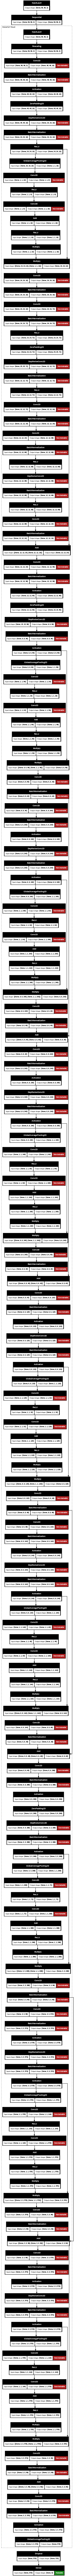

In [ ]:
 #Re-load the model after transfer learning
ft_model = tfk.models.load_model(model_filename)

# Display a summary of the model architecture
ft_model.summary(expand_nested=True)

# Display model architecture with layer shapes and trainable parameters
tfk.utils.plot_model(ft_model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

In [ ]:
# Set the MobileNetV3Small model layers as trainable
ft_model.get_layer('MobileNetV3Small').trainable = True

# Set all MobileNetV3Small layers as non-trainable
for layer in ft_model.get_layer('MobileNetV3Small').layers:
    layer.trainable = False

# Enable training only for Conv2D and DepthwiseConv2D layers
for i, layer in enumerate(ft_model.get_layer('MobileNetV3Small').layers):
    if isinstance(layer, tf.keras.layers.Conv2D) or isinstance(layer, tf.keras.layers.DepthwiseConv2D):
        layer.trainable = True
        print(i, layer.name, type(layer).__name__, layer.trainable)

2 conv Conv2D True
6 expanded_conv_depthwise DepthwiseConv2D True
10 expanded_conv_squeeze_excite_conv Conv2D True
12 expanded_conv_squeeze_excite_conv_1 Conv2D True
15 expanded_conv_project Conv2D True
17 expanded_conv_1_expand Conv2D True
21 expanded_conv_1_depthwise DepthwiseConv2D True
24 expanded_conv_1_project Conv2D True
26 expanded_conv_2_expand Conv2D True
29 expanded_conv_2_depthwise DepthwiseConv2D True
32 expanded_conv_2_project Conv2D True
35 expanded_conv_3_expand Conv2D True
39 expanded_conv_3_depthwise DepthwiseConv2D True
43 expanded_conv_3_squeeze_excite_conv Conv2D True
45 expanded_conv_3_squeeze_excite_conv_1 Conv2D True
48 expanded_conv_3_project Conv2D True
50 expanded_conv_4_expand Conv2D True
53 expanded_conv_4_depthwise DepthwiseConv2D True
57 expanded_conv_4_squeeze_excite_conv Conv2D True
59 expanded_conv_4_squeeze_excite_conv_1 Conv2D True
62 expanded_conv_4_project Conv2D True
65 expanded_conv_5_expand Conv2D True
68 expanded_conv_5_depthwise DepthwiseConv2

0 input_layer_2 False
1 rescaling_1 False
2 conv False
3 conv_bn False
4 activation_18 False
5 expanded_conv_depthwise_pad False
6 expanded_conv_depthwise False
7 expanded_conv_depthwise_bn False
8 re_lu_14 False
9 expanded_conv_squeeze_excite_avg_pool False
10 expanded_conv_squeeze_excite_conv False
11 expanded_conv_squeeze_excite_relu False
12 expanded_conv_squeeze_excite_conv_1 False
13 re_lu_15 False
14 expanded_conv_squeeze_excite_mul False
15 expanded_conv_project False
16 expanded_conv_project_bn False
17 expanded_conv_1_expand False
18 expanded_conv_1_expand_bn False
19 re_lu_16 False
20 expanded_conv_1_depthwise_pad False
21 expanded_conv_1_depthwise False
22 expanded_conv_1_depthwise_bn False
23 re_lu_17 False
24 expanded_conv_1_project False
25 expanded_conv_1_project_bn False
26 expanded_conv_2_expand False
27 expanded_conv_2_expand_bn False
28 re_lu_18 False
29 expanded_conv_2_depthwise False
30 expanded_conv_2_depthwise_bn False
31 re_lu_19 False
32 expanded_conv_2_projec

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ preprocessing (Sequential)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_flip_1 (RandomFlip)      │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_translation_1            │ (None, 96, 96, 3)           │               0 │
│ (RandomTranslation)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MobileNetV3Small (Functional)        │ (None, 576)                 │         939,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ input_layer_2 (InputLayer)      │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ rescaling_1 (Rescaling)         │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ conv (Conv2D)                   │ (None, 48, 48, 16)          │             432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ conv_bn (BatchNormalization)    │ (None, 48, 48, 16)          │              64 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ activation_18 (Activation)      │ (None, 48, 48, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ expanded_conv_depthwise_pad     │ (None, 49, 49, 16)          │               0 │
│ (ZeroPadding2D)                      │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ expanded_conv_depthwise         │ (None, 24, 24, 16)          │             144 │
│ (DepthwiseConv2D)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ expanded_conv_depthwise_bn      │ (None, 24, 24, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ re_lu_14 (ReLU)                 │ (None, 24, 24, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └                                 │ (None, 1, 1, 16)            │               0 │
│ expanded_conv_squeeze_excite_avg_po… │                             │                 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └                                 │ (None, 1, 1, 8)             │             136 │
│ expanded_conv_squeeze_excite_conv    │                             │                 │
│ (Conv2D)                             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └                                 │ (None, 1, 1, 8)             │               0 │
│ expanded_conv_squeeze_excite_relu    │                             │              

 Total params: 952,970 (3.64 MB)

 Trainable params: 643,112 (2.45 MB)

 Non-trainable params: 300,624 (1.15 MB)

 Optimizer params: 9,234 (36.07 KB)

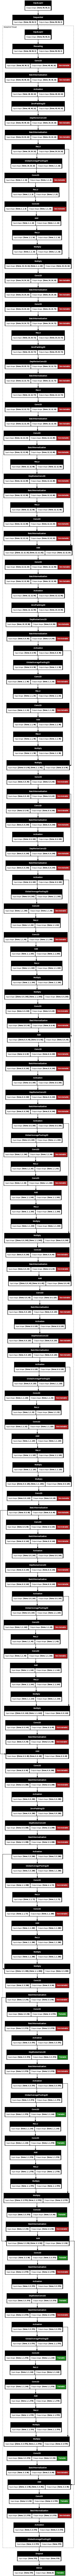

In [ ]:
# Set the number of layers to freeze
N = 124

# Set the first N layers as non-trainable
for i, layer in enumerate(ft_model.get_layer('MobileNetV3Small').layers[:N]):
    layer.trainable = False

# Print layer indices, names, and trainability status
for i, layer in enumerate(ft_model.get_layer('MobileNetV3Small').layers):
    print(i, layer.name, layer.trainable)

# Display a summary of the model architecture
ft_model.summary(expand_nested=True)

# Display model architecture with layer shapes and trainable parameters
tfk.utils.plot_model(ft_model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

In [ ]:
# Compile the model
ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics=['accuracy'])

In [ ]:
# Fine-tune the model
ft_history = ft_model.fit(
    x = X_train,
    y = y_train,
    batch_size = 64,
    epochs = 100,
    validation_data = (X_val, y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True)]
).history

# Calculate and print the final validation accuracy
final_val_accuracy = round(max(ft_history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'Pets_MobileNetV3S_FT_'+str(final_val_accuracy)+'.keras'
ft_model.save(model_filename)

# Delete the model to free up resources
del ft_model

Epoch 1/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 15s 50ms/step - accuracy: 0.5521 - loss: 1.2209 - val_accuracy: 0.6303 - val_loss: 0.9985
Epoch 2/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.5881 - loss: 1.1175 - val_accuracy: 0.6630 - val_loss: 0.9385
Epoch 3/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.6008 - loss: 1.0801 - val_accuracy: 0.6658 - val_loss: 0.9292
Epoch 4/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.6126 - loss: 1.0476 - val_accuracy: 0.6730 - val_loss: 0.8971
Epoch 5/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.6313 - loss: 1.0031 - val_accuracy: 0.6658 - val_loss: 0.8816
Epoch 6/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.6506 - loss: 0.9682 - val_accuracy: 0.6703 - val_loss: 0.8801
Epoch 7/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.6526 - loss: 0.9435 - val_accuracy: 0.6658 - val_loss: 0.9107
Epoch 8/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.6571 - loss: 0.9488 -

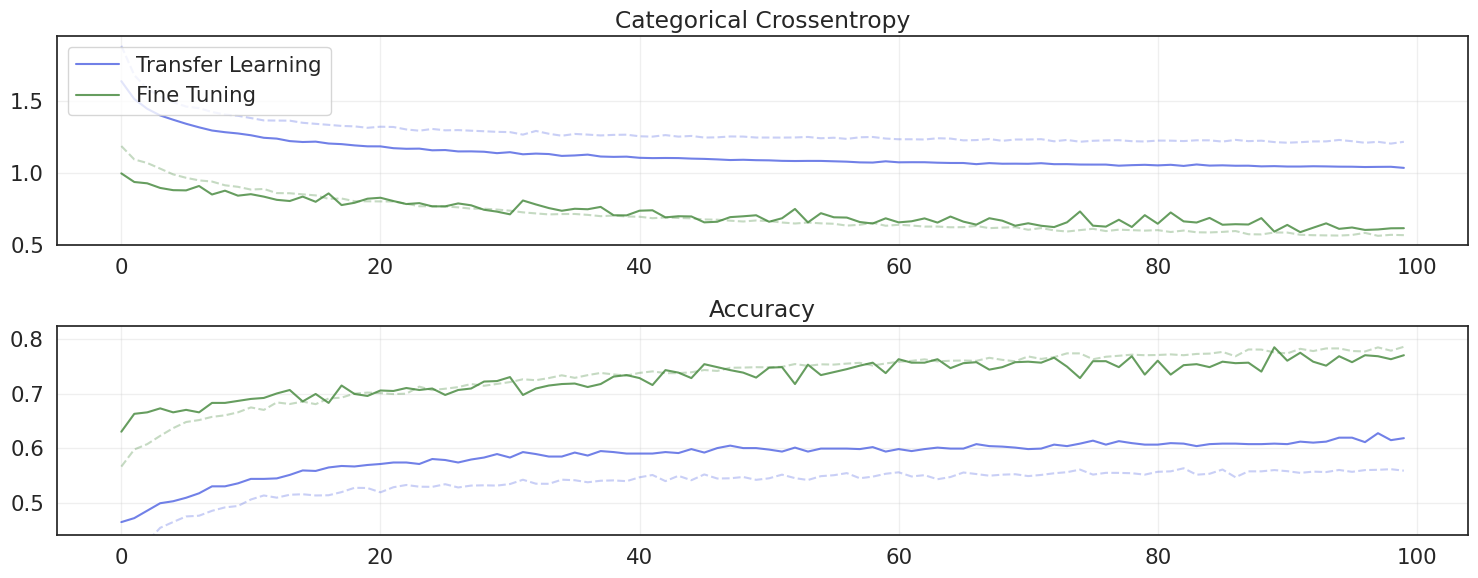

In [ ]:
# Create figure and subplots for loss and accuracy
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 6))

# Plot categorical cross-entropy loss for both Transfer Learning and Fine Tuning stages
ax1.plot(tl_history['loss'], alpha=0.3, color='#4D61E2', linestyle='--')
ax1.plot(tl_history['val_loss'], label='Transfer Learning', alpha=0.8, color='#4D61E2')
ax1.plot(ft_history['loss'], alpha=0.3, color='#408537', linestyle='--')
ax1.plot(ft_history['val_loss'], label='Fine Tuning', alpha=0.8, color='#408537')
ax1.set_title('Categorical Crossentropy')
ax1.legend(loc='upper left')
ax1.grid(alpha=0.3)

# Plot accuracy for both Transfer Learning and Fine Tuning stages
ax2.plot(tl_history['accuracy'], alpha=0.3, color='#4D61E2', linestyle='--')
ax2.plot(tl_history['val_accuracy'], label='Transfer Learning', alpha=0.8, color='#4D61E2')
ax2.plot(ft_history['accuracy'], alpha=0.3, color='#408537', linestyle='--')
ax2.plot(ft_history['val_accuracy'], label='Fine Tuning', alpha=0.8, color='#408537')
ax2.set_title('Accuracy')
ax2.set_ylim([min(tl_history['val_accuracy']) * 0.95, max(ft_history['val_accuracy']) * 1.05])
ax2.grid(alpha=0.3)

# Adjust layout to prevent overlap and display the plots
plt.tight_layout()
plt.show()